In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import tensorflow as tf 
import matplotlib.pyplot as plt
import json

2023-03-22 18:43:58.305069: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 18:43:58.462163: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-22 18:43:58.462191: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-22 18:43:58.496436: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-22 18:43:59.187673: W tensorflow/stream_executor/platform/de

# Import Data

In [4]:
dataset = pd.read_csv('data_nomean.csv', index_col=0)
dataset.tail()

,index,middle,ring,pinky,label
159995,"[0.20588235294117624, 0.20588235294117624, 0.2...","[0.902254409463127, 0.902254409463127, 0.90208...","[0.9900052169121742, 0.9900052169121742, 0.990...","[0.9963689704020832, 0.9963689704020832, 0.996...",4-4
159996,"[0.20517241379310305, 0.20517241379310305, 0.2...","[0.9019139943862396, 0.9019139943862396, 0.901...","[0.9896662412047679, 0.9896662412047679, 0.989...","[0.99636890657134, 0.99636890657134, 0.9963689...",4-4
159997,"[0.20309810671256565, 0.20309810671256565, 0.2...","[0.9015749535299048, 0.9015749535299048, 0.901...","[0.9893274045996283, 0.9893274045996283, 0.989...","[0.9963688975135385, 0.9963688975135385, 0.996...",4-4
159998,"[0.2013651877133101, 0.20307167235494875, 0.20...","[0.9007786395940026, 0.9007786395940026, 0.900...","[0.9884862585194406, 0.9886555782470959, 0.988...","[0.996368908937689, 0.996368908937689, 0.99636...",4-4
159999,"[0.2033898305084746, 0.2033898305084746, 0.205...","[0.9001348366181828, 0.9003040996069657, 0.900...","[0.9881515907852081, 0.9881515907852081, 0.988...","[0.9960072349640712, 0.9960072349640712, 0.996...",4-4


# Create Train/Val/Test Dataset

In [5]:
## X
n_steps = len(json.loads(dataset.iloc[0,0]))
n_features = 4
X = np.empty((dataset.shape[0], n_steps*n_features), dtype=np.float64)
for i in range(X.shape[0]):    
    x = []
    for j in range(n_features):
        arr = list(json.loads(dataset.iloc[i,j]))
        x += arr
    X[i] = np.array(x)

## y
labels = dataset["label"].to_numpy()
le = LabelEncoder()
y_encoded = le.fit_transform(labels)
n_classes = len(np.unique(y_encoded))
y = to_categorical(y_encoded)

## split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)
print(x_train.shape, y_train.shape)

(78400, 120) (78400, 25)


# Model Training

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_dense (Dense)         (None, 128)               15488     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 second_dense (Dense)        (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 third_dense (Dense)         (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 fourth_dense (Dense)        (None, 32)               

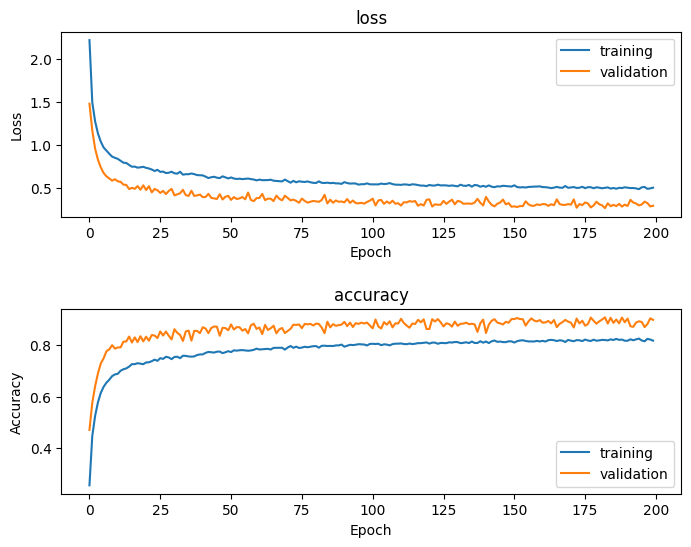

In [10]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(n_steps*n_features,), name='first_dense'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', name='second_dense'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', name='third_dense'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', name='fourth_dense'))
model.add(Dense(n_classes, activation='softmax', name='final_dense'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the MLP model.
history = model.fit(x_train, y_train, epochs=200, batch_size=128, validation_data=(x_val, y_val))
fig, axes = plt.subplots(2,1, figsize=(8,6))
axes[0].plot(history.epoch,history.history['loss'], label='training')
axes[0].plot(history.epoch,history.history['val_loss'], label='validation')
axes[0].set_title('loss')
axes[0].legend(loc='best')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
fig.subplots_adjust(hspace=0.5)
axes[1].plot(history.epoch,history.history['accuracy'], label='training')
axes[1].plot(history.epoch,history.history['val_accuracy'], label='validation')
axes[1].set_title('accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(loc='best');

In [11]:
print("Train accuracy:", history.history["accuracy"][-1])
print("Validation accuracy:", history.history["val_accuracy"][-1])
print("Test accuracy:", model.evaluate(x_test, y_test, verbose=0)[1])

Train accuracy: 0.8158673644065857
Validation accuracy: 0.896101176738739
Test accuracy: 0.8966666460037231


# Model Evaluation

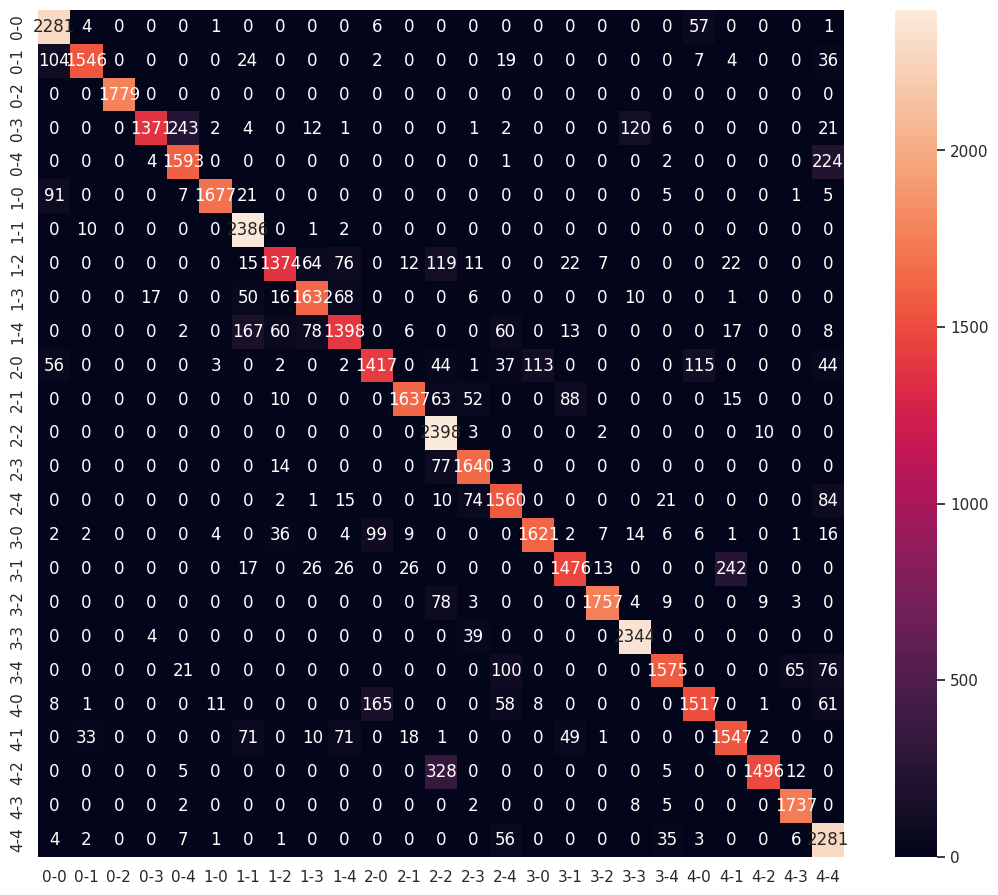

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

y_pred = model.predict(x_test, verbose=0)
y_pred_rd = np.argmax(y_pred, axis=1)
y_test_rd = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_rd, y_pred_rd)
# plt.figure(figsize=(40,40))
# plt.matshow(cm)
df_cm = pd.DataFrame(cm, range(n_classes), range(n_classes))
plt.figure(figsize=(13,11))
sn.set(font_scale=1) # for label size
ticklabels = np.unique(labels)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt="d",
           xticklabels=ticklabels, yticklabels=ticklabels) # font size
plt.show()


In [38]:
import time 
times = []
for i in range(100):
    start = time.time()
    y_prediction = model.predict(x_test, verbose=0) 
    end = time.time()
    times.append((end - start)/x_test.shape[0] * 1000)
print("Inference time: %f ms" % (np.mean(np.array(times))))

Inference time: 0.016485 ms


In [15]:
model.save("mlp")

INFO:tensorflow:Assets written to: mlp/assets
